Lecture 4: Numerical Differentiation
===

Finite difference approximations
---

Forward differences
$$
f'_{FD}(x, h) = \frac{f(x + h) - f(x)}{h}
$$

Backward differences
$$
f'_{BD}(x, h) = \frac{f(x) - f(x-h)}{h}
$$

Central differences
$$
f'_{CD}(x, h) = \frac{f(x+h) - f(x-h)}{2h}
$$

In [1]:
using PyPlot
PyPlot.svg(true)

true

In [2]:
fprime_FD(f, x, h) = (f.(x .+ h) - f.(x))/h
fprime_CD(f, x, h) = (f.(x .+ h) - f.(x .- h))/(2*h)

fprime_CD (generic function with 1 method)

In [3]:
f(x) = tan.(x)

h = 1e-10

fd = fprime_FD(f, 1, h)
cd = fprime_CD(f, 1, h)
exact = 1 + tan(1)^2

println("FD ", fd)
println("CD ", cd)
println("exact ", exact)

FD 3.425517647315246
CD 3.4255187575382706
exact 3.42551882081476


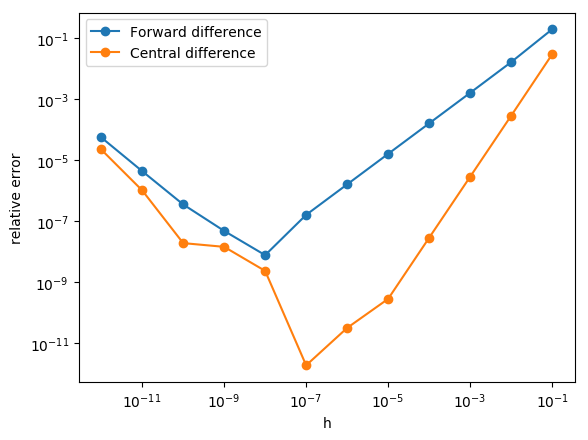

PyObject <matplotlib.legend.Legend object at 0x7f32ad3f6630>

In [4]:
# error analysis
hs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]

fds = [fprime_FD(f, 1, h) for h in hs]
cds = [fprime_CD(f, 1, h) for h in hs]

errors_fd = abs.((fds .- exact)./exact)
errors_cd = abs.((cds .- exact)./exact)

figure()
loglog(hs, errors_fd, "o-", label="Forward difference")
loglog(hs, errors_cd, "o-", label="Central difference")

xlabel("h")
ylabel("relative error")
legend()

Automatic Differentiation
---

We implement Forward Mode automatic differentiation using dual numbers.

Note: For your own programs you can use the ForwardDiff.jl and ReverseDiff.jl packages,
which support most Julia code.

In [ ]:
# defining dual numbers
struct DualNumber
    x::Float64
    xdot::Float64
end

# overloading plus
function Base.:+(a::DualNumber, b::DualNumber)
    return DualNumber(a.x + b.x, a.xdot + b.xdot)
end

# overloading minus
function Base.:-(a::DualNumber, b::DualNumber)
    return DualNumber(a.x - b.x, a.xdot - b.xdot)
end

# overloading times
function Base.:*(a::DualNumber, b::DualNumber)
    return DualNumber(a.x*b.x, a.x*b.xdot + a.xdot*b.x)
end

function Base.:*(a::Real, b::DualNumber)
    return DualNumber(a*b.x, a*b.xdot)
end

# overloading divide
function Base.:/(a::DualNumber, b::DualNumber)
    return DualNumber(a.x/b.x, (a.xdot*b.x - a.x*b.xdot)/(b.x)^2)
end

# overloading a few basic functions
function Base.exp(a::DualNumber)
    return DualNumber(exp(a.x), a.xdot*exp(a.x))
end

function Base.sin(a::DualNumber)
    return DualNumber(sin(a.x), a.xdot*cos(a.x))
end

function Base.cos(a::DualNumber)
    return DualNumber(cos(a.x), -a.xdot*sin(a.x))
end

# comparison with a real number
function Base.:<(a::Real, b::DualNumber)
    return a < b.x
end

function Base.:<(a::DualNumber, b::Real)
    return a.x < b
end

In [ ]:
a = DualNumber(1.0, 1.0)

# a complicated function
f(a) = exp(exp(a))*sin(a) + exp(cos(a) + sin(a))*sin(cos(sin(a)))

In [ ]:
# Computing the derivative of a simple function: tan(x) = sin(x)/cos(x)
f(x) = sin(x)/cos(x)

xs = LinRange(-1, 1, 100)
xduals = [DualNumber(x, 1) for x in xs]
dual_results = f.(xduals)

fs = [d.x for d in dual_results]
fprimes = [d.xdot for d in dual_results]

figure()
plot(xs, fs, label="f(x)")
plot(xs, fprimes, label="f'(x)")

xlabel("x")
legend()

Comparing accuracy between AD, manual evaluation, and finite differences

In [ ]:
# comparing to the exact solution
fprime(x) = 1.0 .+ tan.(x).^2

fprimes_exact = fprime(xs)

figure()
plot(xs, abs.(fprimes - fprimes_exact))

xlabel("x")
ylabel(L"|f'(x) - f'_{AD}(x)|")

In [ ]:
# Autodiff'ing program code

function complicated(x)
    if x > 1
        x = x*x - x
    else
        x = x*x - x - x
    end
    
    for i=1:3
        if x < 1
            x = x*x + exp(x)*sin(x) 
        else
            x = 0.9x
        end
    end
    
    return x
end

In [ ]:
# what does this function do?

xs = LinRange(-1, 1, 100)
ys = complicated.(xs);

In [ ]:
figure()
plot(xs, ys)

xlabel(L"x")
ylabel(L"f(x)")

In [ ]:
# autodiff can handle it!

xduals = [DualNumber(x, 1) for x in xs]
dual_results = complicated.(xduals)

fprimes = [d.xdot for d in dual_results];

In [ ]:
figure()
plot(xs, fprimes)

xlabel(L"x")
ylabel(L"f'(x)")